# Return Behavior
This notebook investigates how the precentage of positive and negative S&P 500 returns changes over time. At the end of the study, I investigate whether the precentage of positive returns is a useful signal for predicting future return behavior.

In [1]:
# File imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf

# Import ISLP-Specific Functions/Classes
from ISLP.models import(
    ModelSpec as MS,
    summarize
)
from statsmodels.tsa.seasonal import seasonal_decompose

# Import settings
plt.style.use('ggplot')

In [2]:
# Download the market data
data = yf.download('^GSPC', period='max', interval='1d', auto_adjust=True)['Close']

# Calculate the returns
data['Daily'] = data['^GSPC'].pct_change()
data['Monthly'] = data['^GSPC'].resample('ME').last().pct_change()
data['Yearly'] = data['^GSPC'].resample('YE').last().pct_change()

[*********************100%***********************]  1 of 1 completed


### Return Distributions
Given daily, monthly, and annual returns for the S&P 500 we focus on the distribution and summary statistics for each sampling period. This section only considers the _full-period_ summary. 

Daily Returns:
Positive Returns(%): 52.4099 | Negative Returns(%): 47.5901
count    24482.000000
mean         0.000309
std          0.011953
min         -0.204669
25%         -0.004551
50%          0.000493
75%          0.005474
max          0.166096
Name: Daily, dtype: float64
Monthly Returns:
Positive Returns(%): 58.9963 | Negative Returns(%): 41.0037
count    817.000000
mean       0.004797
std        0.053438
min       -0.299423
25%       -0.020624
50%        0.008833
75%        0.035271
max        0.391376
Name: Monthly, dtype: float64
Yearly Returns:
Positive Returns(%): 66.6667 | Negative Returns(%): 33.3333
count    69.000000
mean      0.071602
std       0.201613
min      -0.470665
25%      -0.065591
50%       0.107868
75%       0.233090
max       0.450222
Name: Yearly, dtype: float64


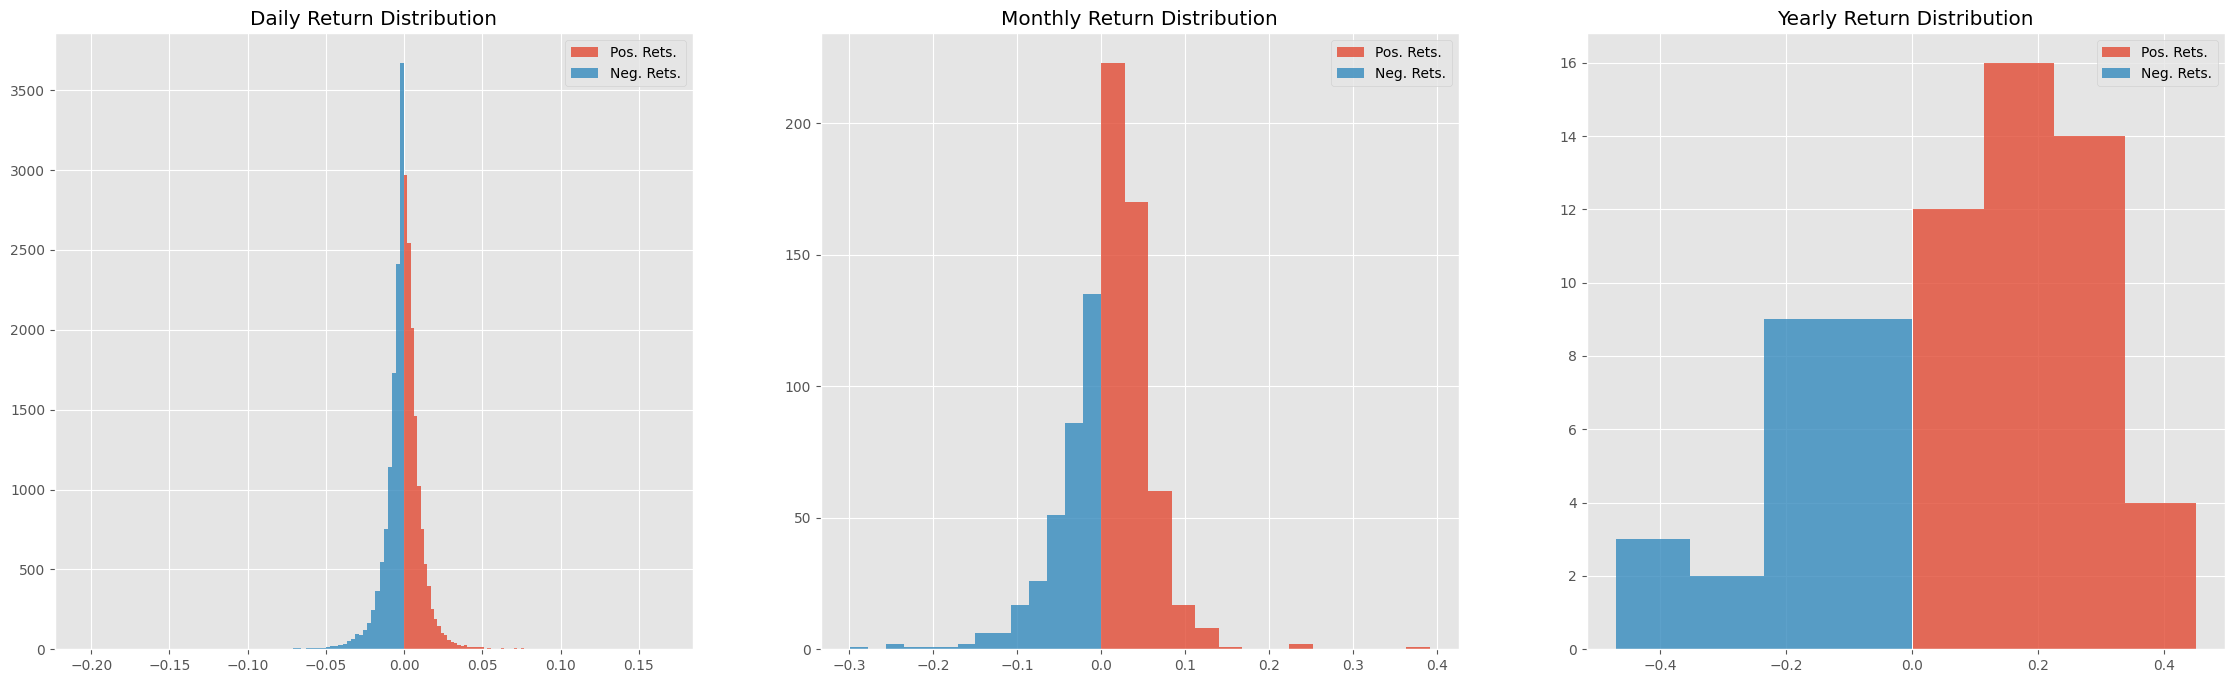

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# Determine the total % of positive and negative returns for earch periodicity
ncol = 0
for col in data.columns:
    if col != '^GSPC':
        return_data = data[col].dropna()

        pos_returns = return_data[return_data > 0]
        neg_returns = return_data[return_data <= 0]

        pos_pct = len(pos_returns) / len(return_data) * 100
        neg_pct = len(neg_returns) / len(return_data) * 100

        print(f'{col} Returns:')
        print(f'Positive Returns(%): {pos_pct:.4f} | Negative Returns(%): {neg_pct:.4f}')
        print(return_data.describe())

        bins = int(np.sqrt(len(return_data)) / 2)

        # Plot the distribution of returns
        axes[ncol].hist(pos_returns, bins=bins, alpha=0.8, label='Pos. Rets.')
        axes[ncol].hist(neg_returns, bins=bins, alpha=0.8, label='Neg. Rets.')
        axes[ncol].set_title(f'{col} Return Distribution')
        axes[ncol].legend()

        ncol += 1

# Display the plot
plt.show()

Observed above, all periods have a larger percentage of positive returns compared to negative returns (which makes intuitive sense). Given that the price of the S&P 500 has advanced since 1928, we would expect a larger number of positive returns. The more intersting observation is that as the time period increases, the percentage of positive returns also increases. One reason for this could be the association between time and smaller measurement intervals. The daily period yields a positive return percentage of 52.41%. Because there is a longer period in a monthly interval, the positive return percentage compounds over the period to yield a greater percentage than that of the shorter interval. This can also be observed extending to the annual interval.

### Estimating E(r) and $\sigma$
Below uses bootstrapping techniques to obtain sample estimates of the expected return and standard deviation of the return distributions of various periods.

In [4]:
# Objective Function
def expected_return(returns, idx):
    """
    * Calulates an estimated expected return based on historical
    * return data.
    """

    return returns.loc[idx].mean()

# Objective Function
def standard_deviation(returns, idx):
    """
    * Calulates an estimated standard deviation based on historical
    * return data.
    """

    return returns.loc[idx].std()

Daily Expected Return Standard Error: 7.856563311256502e-05
Monthly Expected Return Standard Error: 0.0018531171812392634
Yearly Expected Return Standard Error: 0.02335319920078721


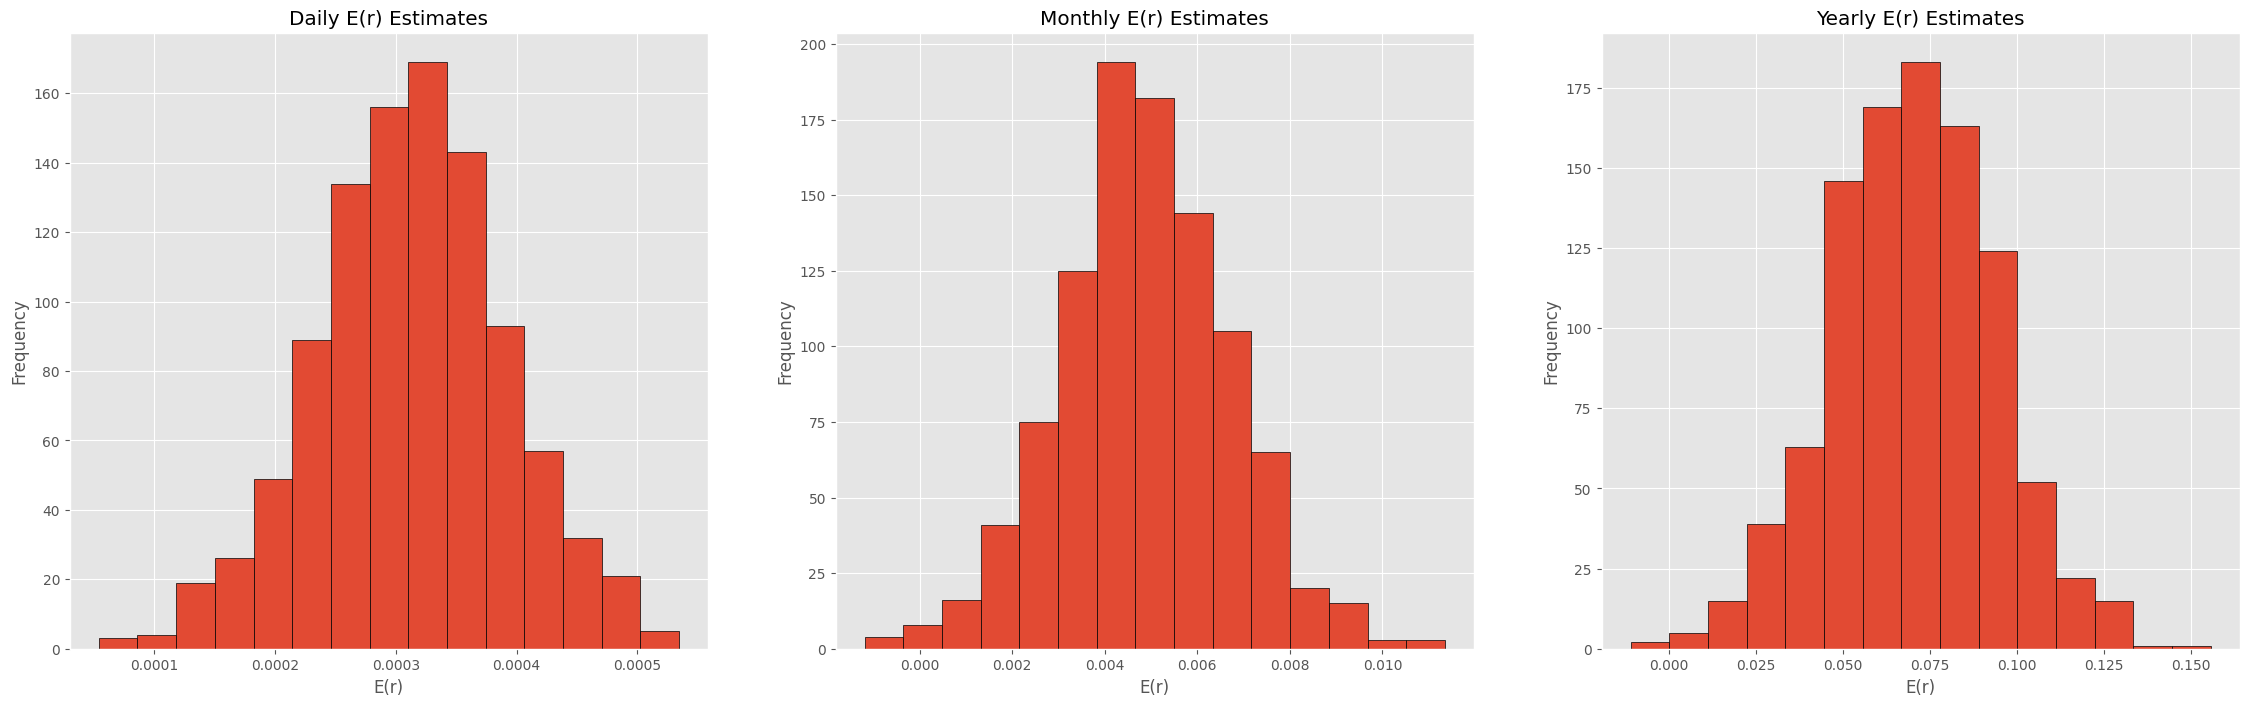

In [5]:
def bootstrapped_Er(func, data, replications=1000, seed=0):
    # Seed the random range
    rand_range = np.random.default_rng(seed)
    n = len(data)

    # Standard error estimates
    se_first, se_second = 0, 0

    # Initialize the expected return estimates to be zero
    er_estimates = np.zeros(replications)

    for i in range(replications):
        # Extract the index range
        idx = rand_range.choice(data.index, n, replace=True)

        # Estimate the expected return
        er_value = expected_return(data, idx)
        er_estimates[i] = er_value

        # Update the standard error parameters
        se_first += er_value
        se_second += er_value ** 2

    return np.sqrt(se_second / replications - (se_first / replications) ** 2), er_estimates

fig, axes = plt.subplots(1, 3, figsize=(28, 8))
ncol = 0

# Process all periods
for col in data.columns:
    if col != '^GSPC':
        # Extract the expected return estimates and standard errors
        er_standard_error, er_estimates = bootstrapped_Er(expected_return, data[col].dropna())

        print(f'{col} Expected Return Standard Error: {er_standard_error}')

        # Plot the estimates of the daily expected return
        axes[ncol].hist(er_estimates, bins=15, edgecolor='black')
        axes[ncol].set_title(f'{col} E(r) Estimates')
        axes[ncol].set_xlabel('E(r)')
        axes[ncol].set_ylabel('Frequency')

        ncol += 1

plt.show()

Daily Standard Deviation Standard Error: 0.00016692686396604757
Monthly Standard Deviation Standard Error: 0.002822452816933581
Yearly Standard Deviation Standard Error: 0.016681943615697546


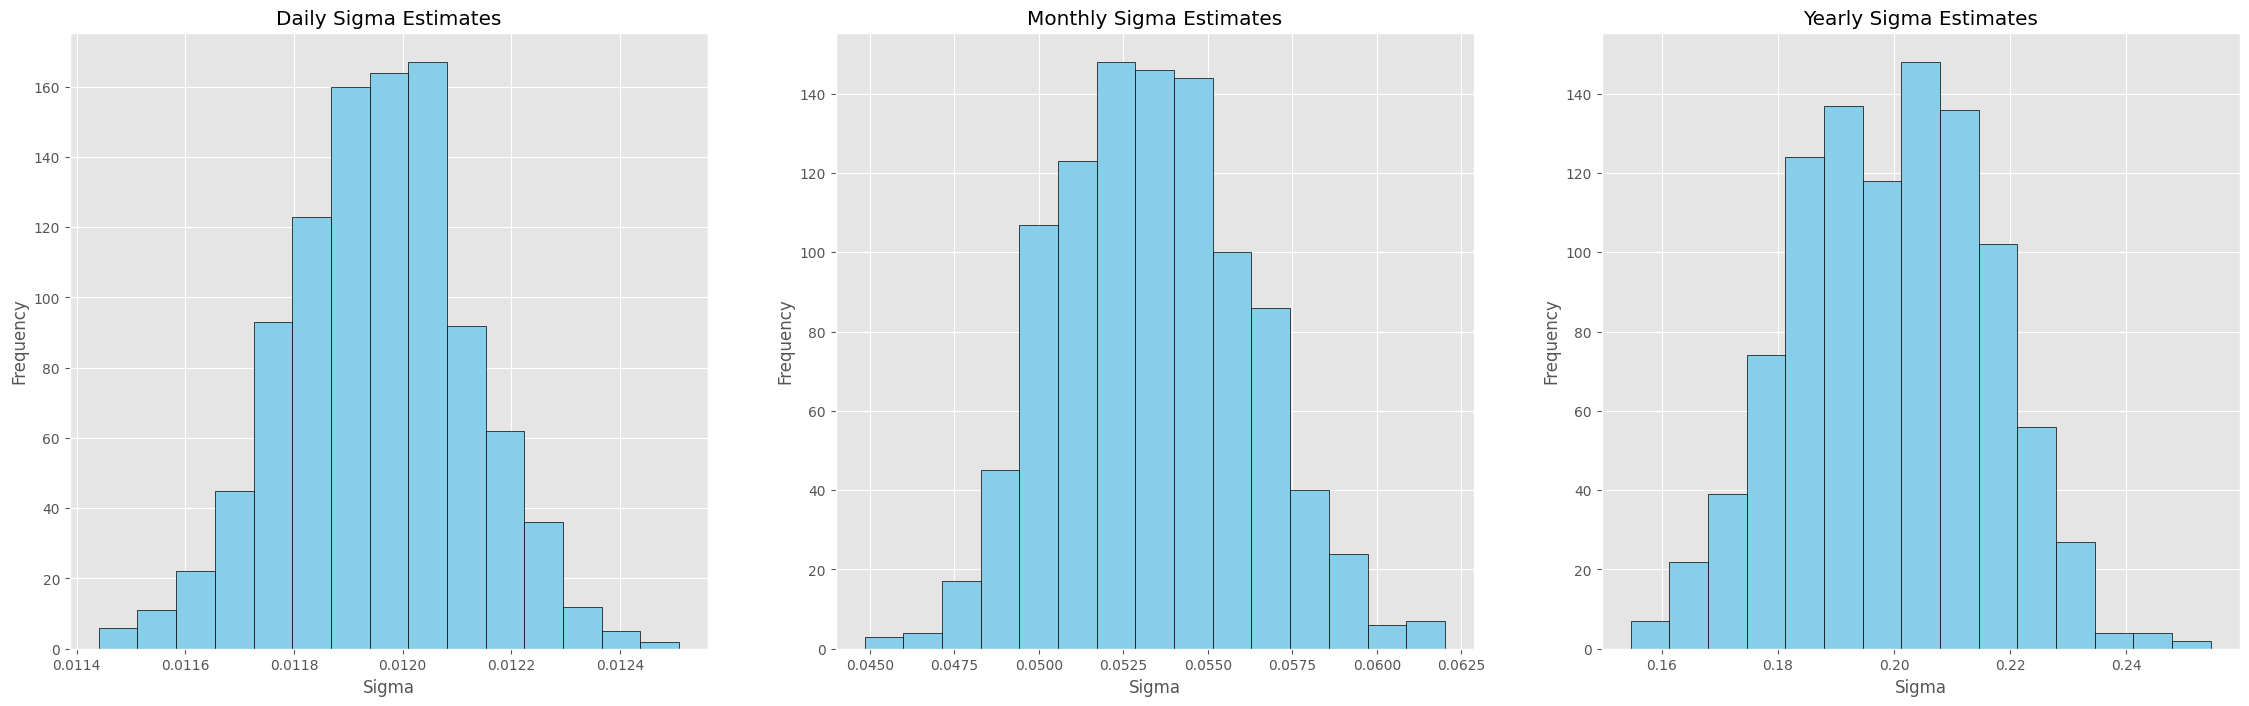

In [6]:
def bootstrapped_sd(func, data, replications=1000, seed=0):
    # Seed the random range
    rand_range = np.random.default_rng(seed)
    n = len(data)

    # Standard error estimates
    se_first, se_second = 0, 0

    # Initialize the expected return estimates to be zero
    sd_estimates = np.zeros(replications)

    for i in range(replications):
        # Extract the index range
        idx = rand_range.choice(data.index, n, replace=True)

        # Estimate the expected return
        sd_value = standard_deviation(data, idx)
        sd_estimates[i] = sd_value

        # Update the standard error parameters
        se_first += sd_value
        se_second += sd_value ** 2

    return np.sqrt(se_second / replications - (se_first / replications) ** 2), sd_estimates

fig, axes = plt.subplots(1, 3, figsize=(28, 8))
ncol = 0

# Process all periods
for col in data.columns:
    if col != '^GSPC':
        # Extract the standard deviation estimates and standard errors
        sd_standard_error, sd_estimates = bootstrapped_sd(standard_deviation, data[col])

        print(f'{col} Standard Deviation Standard Error: {sd_standard_error}')

        # Plot the estimates of the daily expected return
        axes[ncol].hist(sd_estimates, bins=15, edgecolor='black', color='skyblue')
        axes[ncol].set_title(f'{col} Sigma Estimates')
        axes[ncol].set_xlabel('Sigma')
        axes[ncol].set_ylabel('Frequency')

        ncol += 1

plt.show()

### Return Percentages

(Daily) Minimum Positive %: 37.3016
(Daily) Maximum Positive %: 63.0952


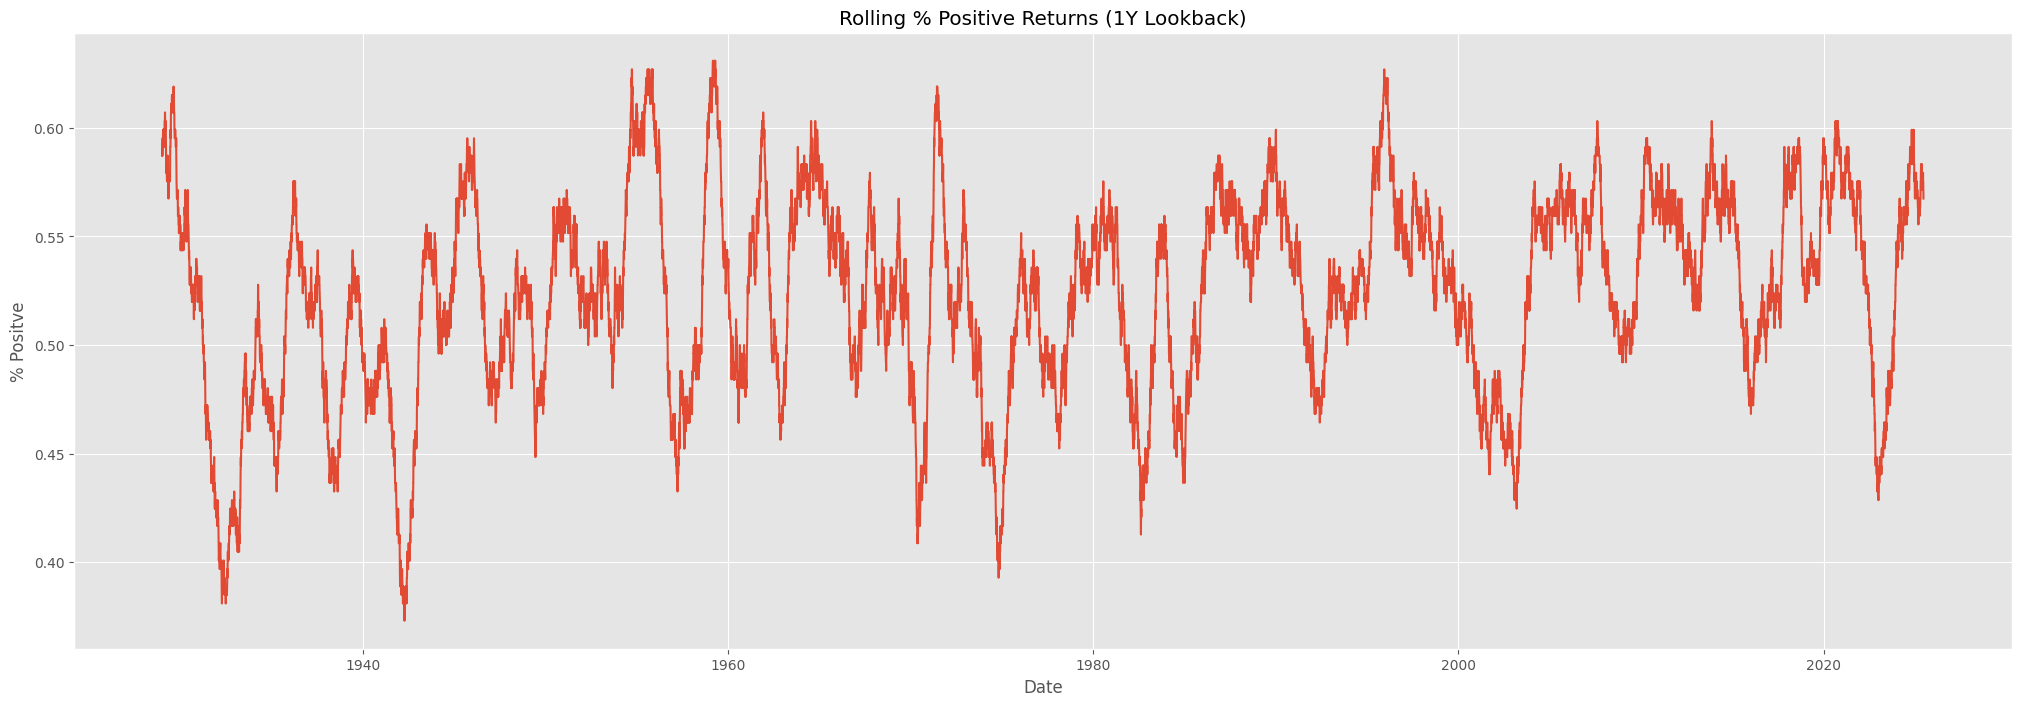

In [7]:
# Calculate the percentage of positive daily returns over a 1-year lookback period
# NOTE: This is on a rolling basis

DAILY_LOOKBACK = 252

# Identify positive (1) and negative (0) returns
positive = (data['Daily'] > 0).astype(int)
daily_pct_positive = positive.rolling(window=DAILY_LOOKBACK).mean()
daily_pct_positive.dropna(inplace=True)

print(f"(Daily) Minimum Positive %: {min(daily_pct_positive)*100:.4f}")
print(f"(Daily) Maximum Positive %: {max(daily_pct_positive)*100:.4f}")

plt.figure(figsize=(25, 8))
plt.plot(daily_pct_positive)
plt.title('Rolling % Positive Returns (1Y Lookback)')
plt.xlabel('Date')
plt.ylabel('% Positve')
plt.show()

Using a 1-year lookback period, the the largest percentage of positive daily returns was 63.10%. The smallest percentage of positive daily returns was 37.30%. On a rolling basis, there is a clear pattern of fluctuation between a higher and lower percentage of positive daily returns over the 1-year lookback.

(Monthly) Minimum Positive %: 16.6667
(Monthly) Maximum Positive %: 91.6667


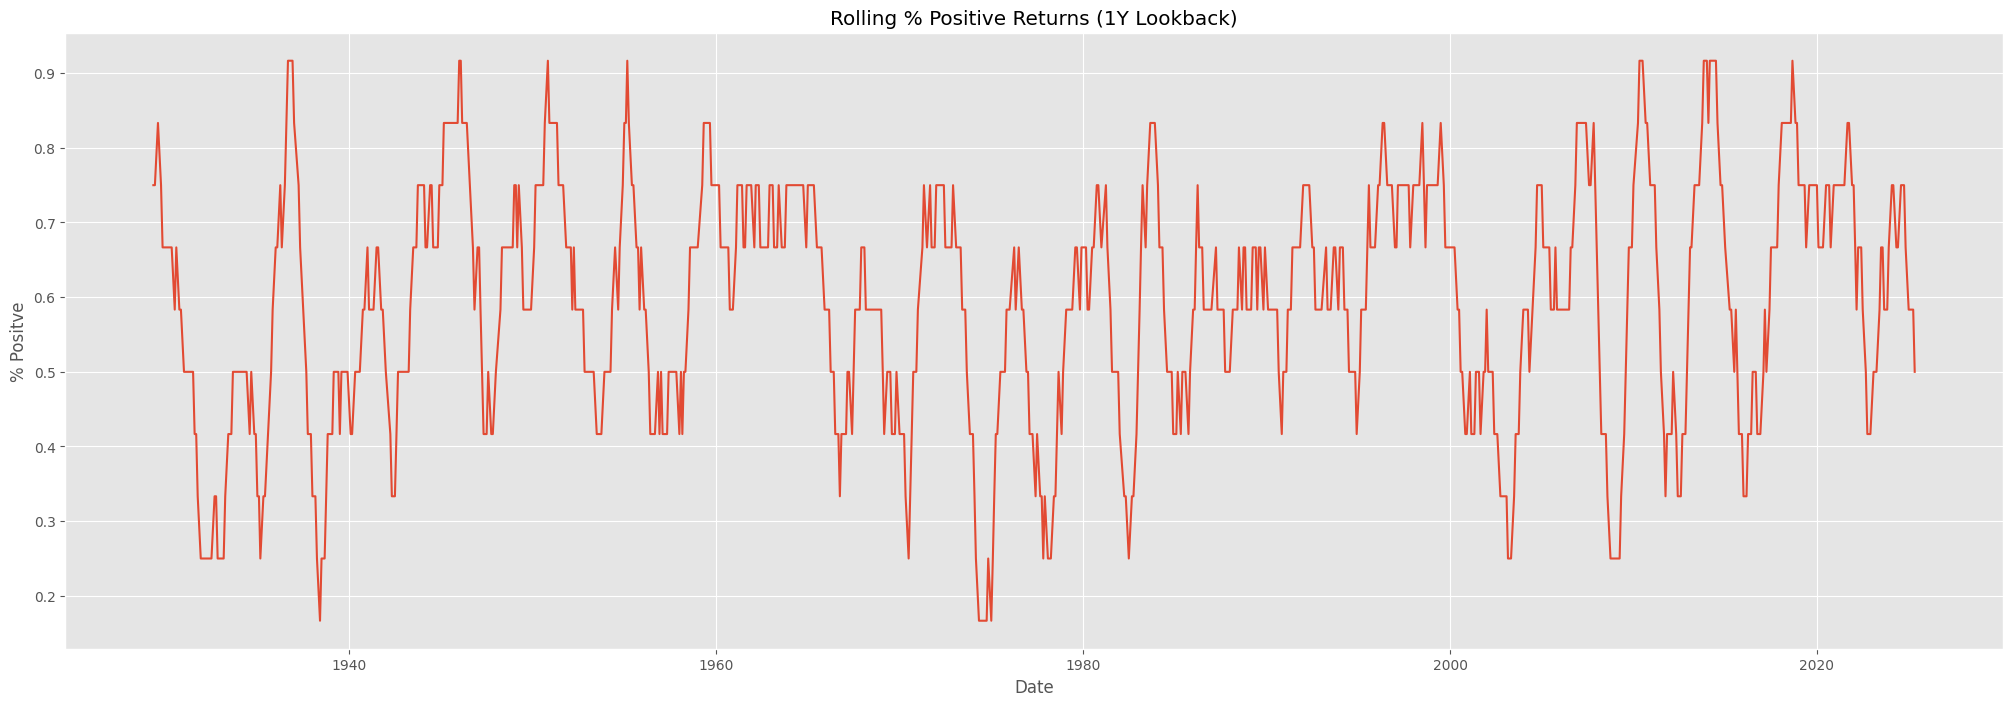

In [8]:
# Calculate the percentage of positive monthly returns over a 1-year lookback period
# NOTE: This is on a rolling basis

MONTHLY_LOOKBACK = 12

# Identify positive (1) and negative (0) returns
positive = (data['Monthly'].dropna() > 0).astype(int)
monthly_pct_positive = positive.rolling(window=MONTHLY_LOOKBACK).mean()
monthly_pct_positive.dropna(inplace=True)

print(f"(Monthly) Minimum Positive %: {min(monthly_pct_positive)*100:.4f}")
print(f"(Monthly) Maximum Positive %: {max(monthly_pct_positive)*100:.4f}")

plt.figure(figsize=(25, 8))
plt.plot(monthly_pct_positive)
plt.title('Rolling % Positive Returns (1Y Lookback)')
plt.xlabel('Date')
plt.ylabel('% Positve')
plt.show()

Using a 1-year lookback period, the the largest percentage of positive monthly returns was 100%. The smallest percentage of positive monthly returns was 8.33%. On a rolling basis, there is a clear pattern of fluctuation between a higher and lower percentage of positive monthly returns over the 1-year lookback.

#### Conclusion (Return Distributions)
It appears that if the rolling percentage either increases or decreases, there is a possibility that the percentage will revert in the opposite direction. A higher percentage of positive returns suggests that investors have earned a higher or positive return due to compounding. Conversely, a lower percentage of positive returns suggests that investors have earned lower or negative returns. Over the full sample period (1928-2025) the daily, monthly, and annual returns have experienced a greater percentage of positive returns. This makes sense because the absolute return for the S&P 500 is largely positive. More interestingly, as the measurement window increased, the percentage of positive returns also increased. This can be explained by the "compounding" of the percentage of positive returns.

### Predictability
To conclude the brief study, I investigate whether the percentage of positive returns is a useful predictor of market returns. I experiment with both regression and classification methods.